In [155]:
!pip install ipython-sql
import pandas as pd
import sqlite3
import datetime as dt
import numpy as np
import requests                 
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
import seaborn as sns

# Schema Definition

In [156]:
# Create a database in RAM
connection = sqlite3.connect(':memory:')

# Creates or opens a file called Assignment3.sl3 with a SQLite3 DB
connection = sqlite3.connect('../datasets/Assignment3.sl3')

%reload_ext sql

#### DB schema document
The schema has 5 tables. The first two are about groundwater quality value and site. The next two are rainfall value and station. The site and station are minimum geography area measuring groundwater quality and rainfall, respectively. The last table is about the region which can connect with gwq and rainfall tables by region as the foreign key.

PK = Primary key(blue)

FK = Foreign key (green)

PK, FK = Primary key and Foregin key (yellow)

The reason why there is an ID attribute in every table is that the data from the data frame with index can not be populated into a table in the database if there is no index column in the table. However, an attribute named index can not be created in a table of SQL. Therefore, an attribute named ID is created to work as an index column in the table.


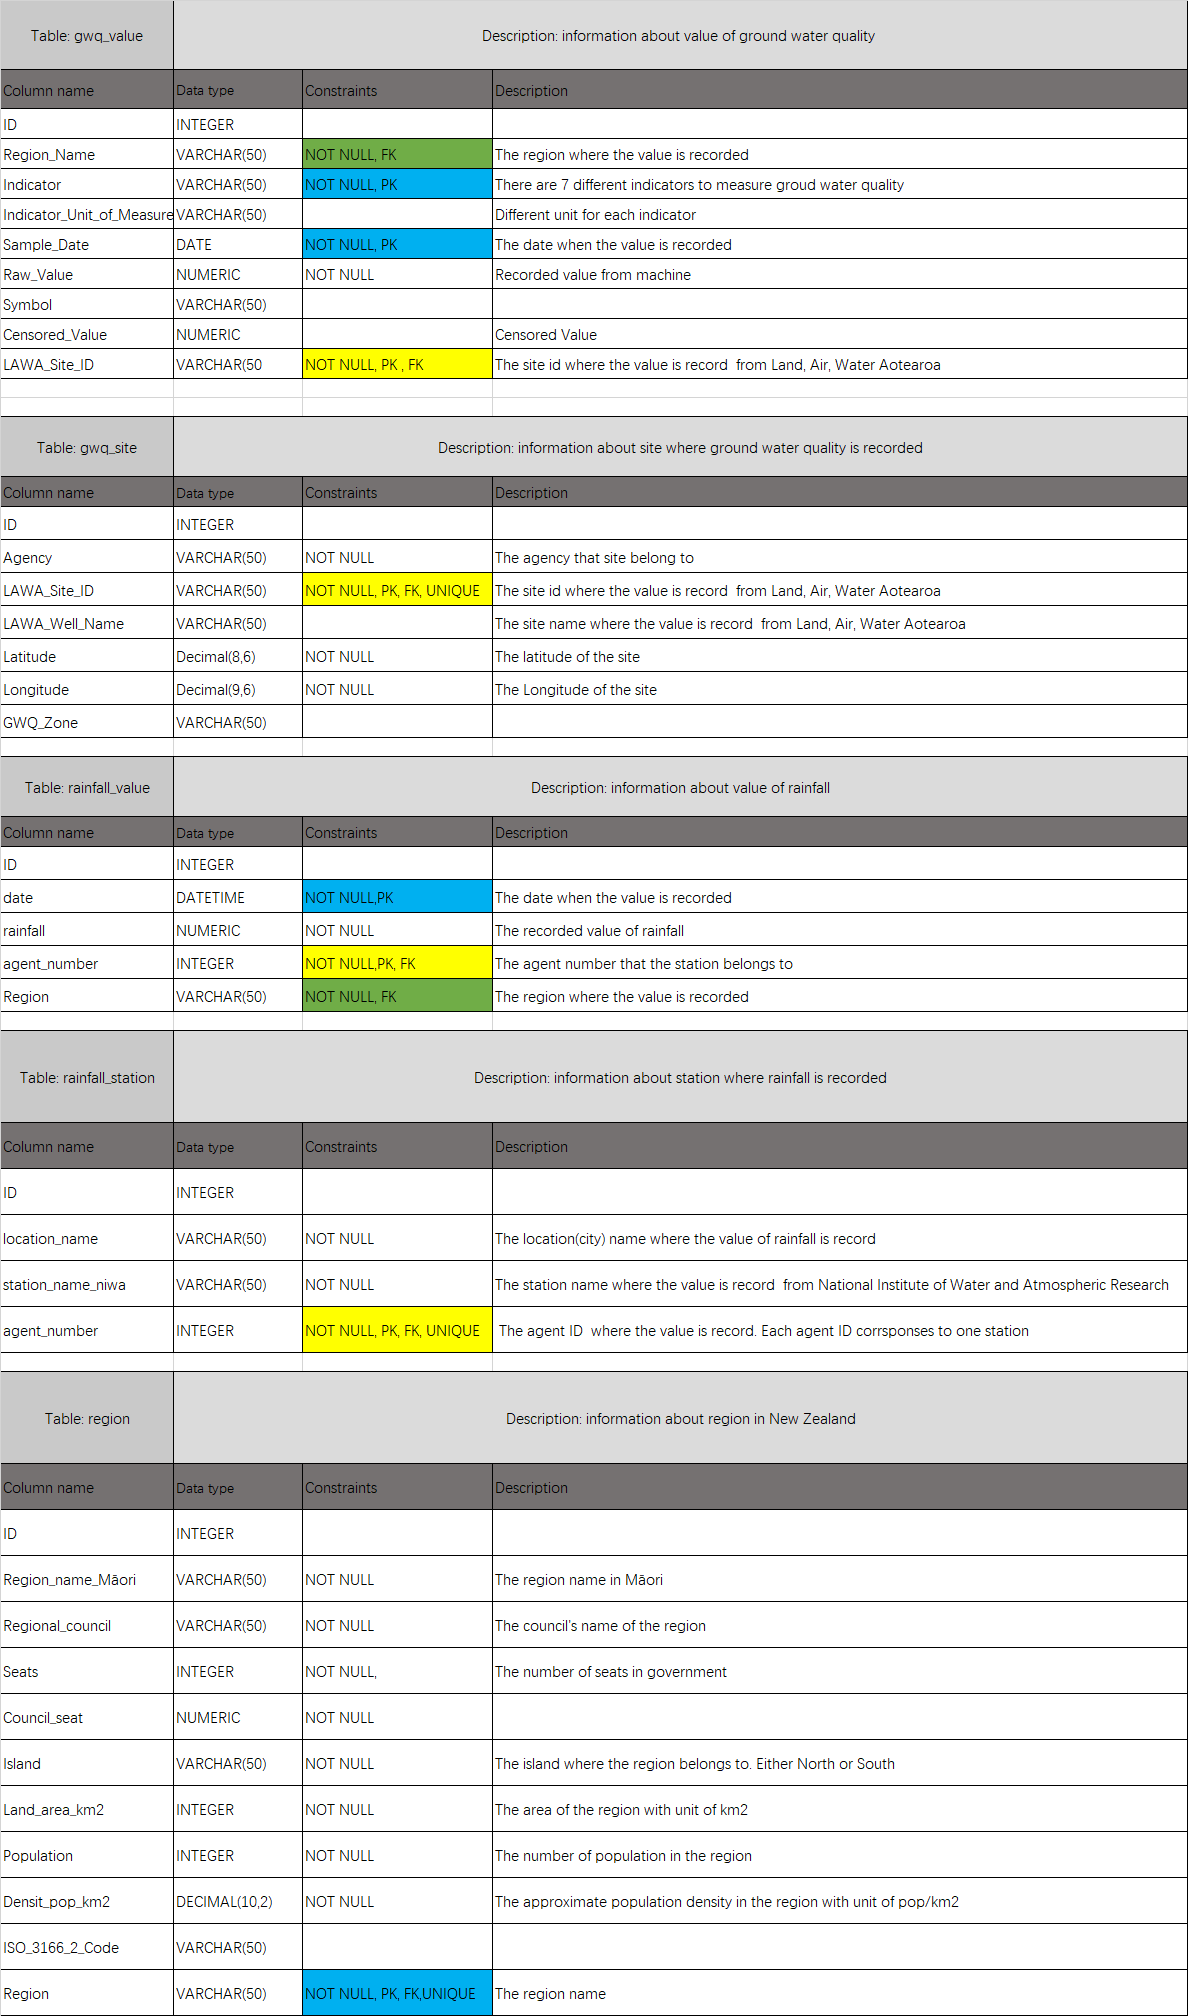

#### Relationships between tables

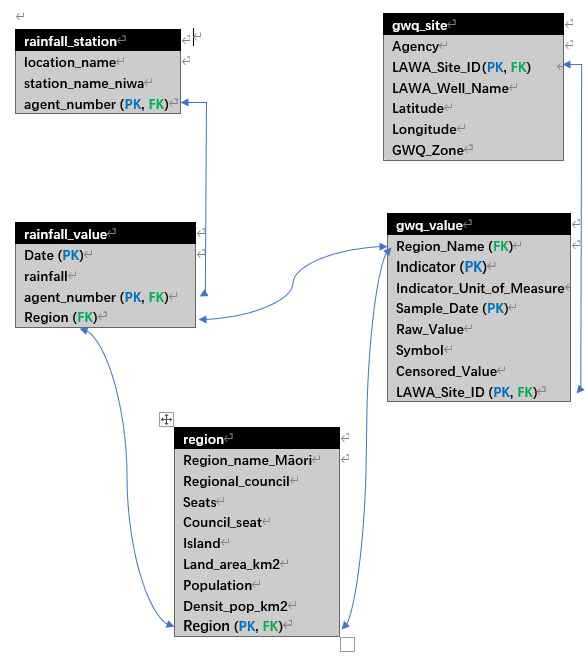

# Creating tables for database schema

#### Creating two tables for groundwater quality dataset

One table describes groundwater quality information called gwq_value and another table describes the site information called gwq_site

In [157]:
%%sql sqlite:///../datasets/Assignment3.sl3
DROP TABLE IF EXISTS gwq_value;

CREATE TABLE gwq_value(
    ID INTEGER,
    Region_Name VARCHAR(50) NOT NULL,  
    Indicator VARCHAR(50) NOT NULL,
    Indicator_Unit_of_Measure VARCHAR(50),
    Sample_Date DATE NOT NULL,
    Raw_Value NUMERIC NOT NULL,
    Symbol VARCHAR(50),
    Censored_Value NUMERIC,
    LAWA_Site_ID VARCHAR(50) NOT NULL,
    PRIMARY KEY (Sample_Date,LAWA_Site_ID,Indicator)
);

Done.
Done.


[]

In [158]:
%%sql sqlite:///../datasets/Assignment3.sl3

DROP TABLE IF EXISTS gwq_site;

CREATE TABLE gwq_site(
    ID INTEGER,
    Agency VARCHAR(50) NOT NULL,  
    LAWA_Site_ID VARCHAR(50) NOT NULL UNIQUE, 
    LAWA_Well_Name VARCHAR(50),
    Latitude Decimal(8,6) NOT NULL,
    Longitude Decimal(9,6) NOT NULL,
    GWQ_Zone VARCHAR(50),
    PRIMARY KEY (LAWA_Site_ID)
);

Done.
Done.


[]

#### Creating two tables for rainfall dataset

One table describes rainfall value information called rainfall_value and another table describes the station information called gwq_station

In [159]:
%%sql sqlite:///../datasets/Assignment3.sl3

DROP TABLE IF EXISTS rainfall_value;

CREATE TABLE rainfall_value(
    ID INTEGER,
    date DATETIME NOT NULL,  
    rainfall NUMERIC NOT NULL,
    agent_number INTEGER NOT NULL,
    Region VARCHAR(50) NOT NULL,
    PRIMARY KEY (date,agent_number)
);

Done.
Done.


[]

In [160]:
%%sql sqlite:///../datasets/Assignment3.sl3
DROP TABLE IF EXISTS rainfall_station;

CREATE TABLE rainfall_station(
    ID INTEGER,
    location_name VARCHAR(50) NOT NULL, 
    station_name_niwa VARCHAR(50) NOT NULL,
    agent_number INTEGER NOT NULL UNIQUE,
    PRIMARY KEY (agent_number)
);

Done.
Done.


[]

####  Creating a table for region dataset

The table describes 16 regions information in New Zealand

In [161]:
%%sql sqlite:///../datasets/Assignment3.sl3

DROP TABLE IF EXISTS region;

CREATE TABLE region(
    ID INTEGER,
    Region_name_Māori VARCHAR(50) NOT NULL,
    Regional_council VARCHAR(50) NOT NULL,
    Seats INTEGER NOT NULL,
    Council_seat NUMERIC NOT NULL,
    Island VARCHAR(50) NOT NULL,
    Land_area_km2 INTEGER NOT NULL,
    Population INTEGER NOT NULL,
    Densit_pop_km2 DECIMAL(10,2) NOT NULL,
    ISO_3166_2_Code VARCHAR(50),
    Region VARCHAR(50) NOT NULL UNIQUE,
    PRIMARY KEY(Region)
);

Done.
Done.


[]

# Data Acquisition,Wrangling and DB Population

The following is some data wrangling to meet the constraints of a database, so all data can be populated into the database. The groundwater quality dataset has two parts: value and site. The rainfall dataset also has two parts: value and station. Therefore, they both are divided into two parts and can be populated into corresponding tables in the database.

Because the monitoring unit of the groundwater quality dataset(second dataset) is the site and the rainfall dataset is the station, two datasets have different geographical Monitoring unit. However, the groundwater quality dataset has variables 'region' and the rainfall dataset(third dataset) only has variable 'location_name' which is cities name. To join them together, a new column named region in rainfall dataset has been created according to relationship between location_name(city) and region.

## Ground water quality dataset
The dataset is downloaded from the website https://www.lawa.org.nz/download-data/#groundwater-quality , which describes groundwater quality in different place of New Zealand from 2005 to 2019

In [162]:
df_gwq = df_gwq = pd.read_excel('C:/Users/yy736/Assignment/datasets/Assignment 3 and 4/groundwater-quality-monitoring-data_statetrend-results_2005-2019.xlsx')
df_gwq

,Region Name,Agency,LAWA Site ID,LAWA Well Name,Latitude,Longitude,GWQ Zone,Indicator,Indicator Unit of Measure,Sample Date,Raw Value,Symbol,Censored Value
0,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-05-01 08:48:00,28,NaN,28.00
1,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-07-20 11:07:00,27,NaN,27.00
2,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-10-09 11:56:00,27,NaN,27.00
3,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2013-01-09 10:55:00,27,NaN,27.00
4,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2013-04-16 12:02:00,29,NaN,29.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127950,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2018-12-11 10:05:00,2.97,NaN,2.97
127951,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-03-22 13:20:00,2.55,NaN,2.55
127952,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-06-14 13:33:00,2.62,NaN,2.62
127953,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-09-13 13:45:00,2.53,NaN,2.53


In [163]:
# The name of attribute can not contain space 
df_gwq.rename(columns = {'Region Name':'Region_Name','LAWA Site ID':'LAWA_Site_ID','LAWA Well Name':'LAWA_Well_Name','GWQ Zone':'GWQ_Zone','Indicator Unit of Measure':'Indicator_Unit_of_Measure','Sample Date':'Sample_Date','Raw Value':'Raw_Value','Censored Value':'Censored_Value'},inplace = True)
# The name of attribute can not be 'index'
df_gwq['ID'] = df_gwq.index.values
df_gwq =df_gwq.set_index('ID')
df_gwq

,Region_Name,Agency,LAWA_Site_ID,LAWA_Well_Name,Latitude,Longitude,GWQ_Zone,Indicator,Indicator_Unit_of_Measure,Sample_Date,Raw_Value,Symbol,Censored_Value
ID,,,,,,,,,,,,,
0,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-05-01 08:48:00,28,NaN,28.00
1,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-07-20 11:07:00,27,NaN,27.00
2,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2012-10-09 11:56:00,27,NaN,27.00
3,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2013-01-09 10:55:00,27,NaN,27.00
4,Auckland,Auckland Council,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Chloride,g/m³,2013-04-16 12:02:00,29,NaN,29.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127950,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2018-12-11 10:05:00,2.97,NaN,2.97
127951,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-03-22 13:20:00,2.55,NaN,2.55
127952,West Coast,West Coast Regional Council,LAWA-101294,NaN,-42.716871,170.964193,Hokitika,Water Level,NaN,2019-06-14 13:33:00,2.62,NaN,2.62


### Data validation for gwq_value table

In [164]:
# Accessing data only about value from the whole dataset
df_gwq_value = df_gwq.loc[:,['Region_Name','LAWA_Site_ID','Indicator','Indicator_Unit_of_Measure','Sample_Date','Raw_Value','Symbol','Censored_Value']]
# To meet constraint that the primary key is unique for gwq_value table 
df_gwq_value.drop_duplicates(subset = ['Sample_Date','LAWA_Site_ID','Indicator'],inplace = True)
# Checking meet constraints of NOT NULL for gwq_value table 
print(df_gwq_value['Region_Name'].isnull().sum())
print(df_gwq_value['Indicator'].isnull().sum())
print(df_gwq_value['Sample_Date'].isnull().sum())
# Dropping missing value in Sample_Date to meet the constraint of NOT NULL for the table 
df_gwq_value = df_gwq_value[df_gwq['Sample_Date'].notnull()]
df_gwq_value

0
0
176


<ipython-input-164-9608dd6cf7e6>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gwq_value = df_gwq_value[df_gwq['Sample_Date'].notnull()]


,Region_Name,LAWA_Site_ID,Indicator,Indicator_Unit_of_Measure,Sample_Date,Raw_Value,Symbol,Censored_Value
ID,,,,,,,,
0,Auckland,LAWA-101648,Chloride,g/m³,2012-05-01 08:48:00,28,NaN,28.00
1,Auckland,LAWA-101648,Chloride,g/m³,2012-07-20 11:07:00,27,NaN,27.00
2,Auckland,LAWA-101648,Chloride,g/m³,2012-10-09 11:56:00,27,NaN,27.00
3,Auckland,LAWA-101648,Chloride,g/m³,2013-01-09 10:55:00,27,NaN,27.00
4,Auckland,LAWA-101648,Chloride,g/m³,2013-04-16 12:02:00,29,NaN,29.00
...,...,...,...,...,...,...,...,...
127950,West Coast,LAWA-101294,Water Level,NaN,2018-12-11 10:05:00,2.97,NaN,2.97
127951,West Coast,LAWA-101294,Water Level,NaN,2019-03-22 13:20:00,2.55,NaN,2.55
127952,West Coast,LAWA-101294,Water Level,NaN,2019-06-14 13:33:00,2.62,NaN,2.62


### Data validation for gwq_site table

In [165]:
# Accessing data only about site from the whole dataset
df_gwq_site = df_gwq.loc[:,['LAWA_Site_ID','LAWA_Well_Name','Latitude','Longitude','GWQ_Zone','Agency']]
# To meet constraint that the primary key is unique for gwq_site table 
df_gwq_site.drop_duplicates(subset = ['LAWA_Site_ID'],inplace = True)
# Checking meet constraints of NOT NULL for gwq_site table
print(df_gwq_site['LAWA_Site_ID'].isnull().sum())
df_gwq_site

0


,LAWA_Site_ID,LAWA_Well_Name,Latitude,Longitude,GWQ_Zone,Agency
ID,,,,,,
0,LAWA-101648,Patumahoe Springs,-37.200517,174.847670,Pukekohe North Volcanic,Auckland Council
150,LAWA-101661,Ostrich Farm Obs NO2,-37.167387,174.869818,Pukekohe Kaawa,Auckland Council
354,LAWA-101663,Fielding Rd Sand,-37.116168,174.962976,Bombay Drury Sand,Auckland Council
559,LAWA-101664,Fielding Rd Volc,-37.116168,174.962976,Bombay Volcanic,Auckland Council
831,LAWA-101665,Hillview Springs,-37.169148,174.986554,Bombay Volcanic,Auckland Council
...,...,...,...,...,...,...
126482,LAWA-101290,NaN,-42.858178,171.004170,Hokitika,West Coast Regional Council
126784,LAWA-101291,NaN,-42.298318,171.578026,Grey,West Coast Regional Council
127062,LAWA-101292,GW 0134 @ Orowaiti,-41.801421,171.610301,Kawatiri,West Coast Regional Council


#### Writing data into SQLite tables

In [166]:
df_gwq_value.to_sql('gwq_value', connection, if_exists='append',)
connection.commit()

In [167]:
df_gwq_site.to_sql('gwq_site', connection, if_exists='append',)
connection.commit()

## Rainfall Dataset
The rainfall dataset is downloaded from stats NZ https://www.stats.govt.nz/indicators/rainfall, which describes rainfall in different place of New Zealand from 1965 to 2019.(Downloaded file is a zip file, dataset used here is a csv file named daily_data)

The original rainfall dataset does not have the region column, to connect with region data, a new column named region has been created according to the relationship between location_name(city) and region.

In [168]:
# Reading datset from local disk
df_rainfall = pd.read_csv('C:/Users/yy736/Assignment/datasets/Assignment 3 and 4/daily_data.csv') 
df_rainfall

,location_name,date,rainfall,station_name_niwa,agent_number
0,Auckland,1960-01-01,0.0,Auckland Aero,1962
1,Auckland,1960-01-02,0.0,Auckland Aero,1962
2,Auckland,1960-01-03,9.2,Auckland Aero,1962
3,Auckland,1960-01-04,0.0,Auckland Aero,1962
4,Auckland,1960-01-05,0.0,Auckland Aero,1962
...,...,...,...,...,...
657445,Whangarei,2019-12-27,0.0,Whangarei Aero Aws,1287
657446,Whangarei,2019-12-28,0.0,Whangarei Aero Aws,1287
657447,Whangarei,2019-12-29,0.0,Whangarei Aero Aws,1287
657448,Whangarei,2019-12-30,0.0,Whangarei Aero Aws,1287


In [169]:
# The name of attribute can not be 'index'
df_rainfall['ID'] = df_rainfall.index.values
df_rainfall =df_rainfall.set_index('ID')
# New column named region has been created according relationship between location_name(city) and region.
d = {'Auckland':'Auckland','Blenheim':'Marlborough','Christchurch':'Canterbury','Dannevirke':'Manawatū-Whanganui','Dunedin':'Otago','Gisborne':'Gisborne','Gore':'Southland','Hamilton':'Waikato','Hokitika':'West Coast','Invercargill':'Southland','Kerikeri':'Northland','Lake Tekapo':'Canterbury','Masterton':'Wellington','Milford Sound':'Southland','Napier':"Hawke's Bay",'Nelson':'Tasman','New Plymouth':'Taranaki','Queenstown':'Otago','Reefton':'West Coast','Rotorua':'Bay of Plenty','Tara Hills':'Otago','Taumarunui':'Manawatū-Whanganui','Taupo':'Waikato','Tauranga':'Bay of Plenty','Timaru':'Canterbury','Waiouru':'Manawatū-Whanganui','Wellington':'Wellington','Whanganui':'Manawatū-Whanganui','Whangaparaoa':'Auckland','Whangarei':'Northland'}
df_rainfall['Region']= df_rainfall['location_name'].map(d)  
df_rainfall

,location_name,date,rainfall,station_name_niwa,agent_number,Region
ID,,,,,,
0,Auckland,1960-01-01,0.0,Auckland Aero,1962,Auckland
1,Auckland,1960-01-02,0.0,Auckland Aero,1962,Auckland
2,Auckland,1960-01-03,9.2,Auckland Aero,1962,Auckland
3,Auckland,1960-01-04,0.0,Auckland Aero,1962,Auckland
4,Auckland,1960-01-05,0.0,Auckland Aero,1962,Auckland
...,...,...,...,...,...,...
657445,Whangarei,2019-12-27,0.0,Whangarei Aero Aws,1287,Northland
657446,Whangarei,2019-12-28,0.0,Whangarei Aero Aws,1287,Northland
657447,Whangarei,2019-12-29,0.0,Whangarei Aero Aws,1287,Northland


### Data validation for rainfall_value table

In [170]:
# Accessing data only about value from the whole dataset
df_rainfall_value = df_rainfall.loc[:,['date','Region','rainfall','agent_number']]
# To meet constraint that the primary key is unique for rainfall_value table 
df_rainfall_value.drop_duplicates(subset = ['date','agent_number'],inplace = True)
# Checking meet constraints of NOT NULL for rainfall_value table 
print(df_rainfall_value['date'].isnull().sum())
print(df_rainfall_value['rainfall'].isnull().sum())
print(df_rainfall_value['agent_number'].isnull().sum())
print(df_rainfall_value['Region'].isnull().sum())
df_rainfall_value

0
0
0
0


,date,Region,rainfall,agent_number
ID,,,,
0,1960-01-01,Auckland,0.0,1962
1,1960-01-02,Auckland,0.0,1962
2,1960-01-03,Auckland,9.2,1962
3,1960-01-04,Auckland,0.0,1962
4,1960-01-05,Auckland,0.0,1962
...,...,...,...,...
657445,2019-12-27,Northland,0.0,1287
657446,2019-12-28,Northland,0.0,1287
657447,2019-12-29,Northland,0.0,1287


### Data validation for rainfall_station table

In [171]:
# Accessing data only about station from the whole dataset
df_rainfall_station = df_rainfall.loc[:,['location_name','station_name_niwa','agent_number']]
# To meet constraint that the primary key is unique for rainfall_station table 
df_rainfall_station.drop_duplicates(subset = ['agent_number'],inplace = True)
# Checking meet constraints of NOT NULL for rainfall_station table 
print(df_rainfall_station['location_name'].isnull().sum())
print(df_rainfall_station['station_name_niwa'].isnull().sum())
print(df_rainfall_station['agent_number'].isnull().sum())
df_rainfall_station

0
0
0


,location_name,station_name_niwa,agent_number
ID,,,
0,Auckland,Auckland Aero,1962
21915,Blenheim,Blenheim Aero Aws,4326
43830,Christchurch,Christchurch Aero,4843
65745,Dannevirke,Dannevirke,2534
87660,Dunedin,"Dunedin, Musselburgh Ews",15752
109575,Gisborne,Gisborne Aws,2810
131490,Gore,Gore Aws,5778
153405,Hamilton,Hamilton Aws,2112
175320,Hokitika,Hokitika Aero,3909


In [172]:
df_rainfall_value.to_sql('rainfall_value', connection, if_exists='append',)
connection.commit()
df_rainfall_station.to_sql('rainfall_station', connection, if_exists='append',)
connection.commit()

## Region Dataset
The original region dataset only has region name in Māori, to connect with gwq and rainfall, a new column named region has been created.

There is a special region named Nelson which is considered as an independent region. However, in the rainfall and groundwater quality dataset, Nelson is considered as a city in the Marlborough region. The result of why Nelson is considered differently in the different source is that Nelson City is bordered to the west and south-west by Tasman District Council and to the north-east, east and south-east by Marlborough District Council (https://en.wikipedia.org/wiki/Nelson,_New_Zealand#cite_note-NZ_population_data_2018-1).

Here, to easily connect 5 tables, Nelson is considered as a city in the Marlborough region.

In [173]:
url = "https://en.wikipedia.org/wiki/Regions_of_New_Zealand"
response = requests.get(url)
response
scraping_html_table = BeautifulSoup(response.content, "lxml") 
scraping_html_table = scraping_html_table.find_all("table", "wikitable")
scraping_html_table
df_region = pd.read_html(str(scraping_html_table))
df_region = df_region[0]
df_region

,Unnamed: 0,Region name(name in Māori if different),Regional council,Seats,Council seat,Island,Land area(km2)[21],Population[22],Density (pop./km2),ISO 3166-2 Code
0,1,NorthlandTe Tai Tokerau,Northland Regional Council,9,Whangārei,North,12504,194600,15.56,NZ-NTL
1,2,Auckland(1)Tāmaki-makau-rau,Auckland Council,21,Auckland,North,4941,1717500,347.60,NZ-AUK
2,3,Waikato,Waikato Regional Council,14,Hamilton,North,23900,496700,20.78,NZ-WKO
3,4,Bay of PlentyTe Moana-a-Toi,Bay of Plenty Regional Council,14,Whakatāne,North,12072,337300,27.94,NZ-BOP
4,5,Gisborne(1)(2)Te Tai Rāwhiti,Gisborne District Council,14,Gisborne,North,8385,50700,6.05,NZ-GIS
5,6,Hawke's BayTe Matau-a-Māui,Hawke's Bay Regional Council,9,Napier,North,14138,178600,12.63,NZ-HKB
6,7,Taranaki,Taranaki Regional Council,11,Stratford,North,7254,124600,17.18,NZ-TKI
7,8,Manawatū-Whanganui,Horizons Regional Council,12,Palmerston North,North,22221,254300,11.44,NZ-MWT
8,9,WellingtonTe Whanga-nui-a-Tara,Greater Wellington Regional Council,13,Wellington,North,8049,542000,67.34,NZ-WGN
9,10,Tasman(1)Te Tai-o-Aorere,Tasman District Council,13,Richmond,South,9616,56400,5.87,NZ-TAS


#### manipulating region data so it can be populated into database

In [174]:
# Creating new column named Region
df_region['Region'] = ['Northland','Auckland','Waikato','Bay of Plenty','Gisborne',"Hawke's Bay",'Taranaki','Manawatū-Whanganui',
'Wellington','Tasman','Nelson','Marlborough','West Coast','Canterbury','Otago','Southland']
# Removing unnecessary column
df_region.drop('Unnamed: 0',inplace = True,axis = 1)
# The name of attribute can not be 'index'
df_region['ID'] = df_region.index.values
df_region =df_region.set_index('ID')
# The name of attribute can not contain space 
df_region.rename(columns = {'Region name(name in Māori if different)':'Region_name_Māori','Regional council':'Regional_council','Council seat':'Council_seat','Land area(km2)[21]':'Land_area_km2','Population[22]':'Population','Density (pop./km2)':'Densit_pop_km2','ISO 3166-2 Code':'ISO_3166_2_Code'},inplace = True)
# Putting Nelson into Marlborough region
df_region.loc[11,['Population']] = df_region.loc[11,['Population']] + df_region.loc[10,['Population']]
df_region.loc[11,['Land_area_km2']] = df_region.loc[11,['Land_area_km2']] + df_region.loc[10,['Land_area_km2']]
print(df_region.loc[11,['Population']])
print(df_region.loc[11,['Land_area_km2']])
df_region.loc[11,['Densit_pop_km2']]= round(104800/ 10880,2)
# drop Nelson row
df_region = df_region.drop(10)
df_region

Population    104800
Name: 11, dtype: object
Land_area_km2    10880
Name: 11, dtype: object


,Region_name_Māori,Regional_council,Seats,Council_seat,Island,Land_area_km2,Population,Densit_pop_km2,ISO_3166_2_Code,Region
ID,,,,,,,,,,
0,NorthlandTe Tai Tokerau,Northland Regional Council,9,Whangārei,North,12504,194600,15.56,NZ-NTL,Northland
1,Auckland(1)Tāmaki-makau-rau,Auckland Council,21,Auckland,North,4941,1717500,347.60,NZ-AUK,Auckland
2,Waikato,Waikato Regional Council,14,Hamilton,North,23900,496700,20.78,NZ-WKO,Waikato
3,Bay of PlentyTe Moana-a-Toi,Bay of Plenty Regional Council,14,Whakatāne,North,12072,337300,27.94,NZ-BOP,Bay of Plenty
4,Gisborne(1)(2)Te Tai Rāwhiti,Gisborne District Council,14,Gisborne,North,8385,50700,6.05,NZ-GIS,Gisborne
5,Hawke's BayTe Matau-a-Māui,Hawke's Bay Regional Council,9,Napier,North,14138,178600,12.63,NZ-HKB,Hawke's Bay
6,Taranaki,Taranaki Regional Council,11,Stratford,North,7254,124600,17.18,NZ-TKI,Taranaki
7,Manawatū-Whanganui,Horizons Regional Council,12,Palmerston North,North,22221,254300,11.44,NZ-MWT,Manawatū-Whanganui
8,WellingtonTe Whanga-nui-a-Tara,Greater Wellington Regional Council,13,Wellington,North,8049,542000,67.34,NZ-WGN,Wellington


In [175]:
df_region.to_sql('region', connection, if_exists='append',)
connection.commit()

# SQLite Queries and Analysis

### Groundwater quality analysis: 9 sites ground water quality in Auckland from 2005 to 2019
The analysis is based on the first analysis of assignment 4 but the period is from 2005 to 2019 instead of from 2003 to 2019

#### Joining gwq_value with gwq_site to create a view named gwq
The format of Sample_Date in gwq_value is still %Y-%m-%d %H:%M:%S so it needs to be replaced with %Y-%m-%d in gwq that gwq can connect with the rainfall table

In [176]:
%%sql
DROP VIEW IF EXISTS gwq_datetime_ns;

CREATE VIEW gwq_datetime_ns AS
SELECT 
   gv.Region_Name,gv.Indicator,gv.Indicator_Unit_of_Measure,gv.Sample_Date,gv.Raw_Value,gv.Symbol,gv.Censored_Value,gv.LAWA_Site_ID
    ,gs.LAWA_Well_Name, gs.Latitude,gs.Longitude,gs.GWQ_Zone AS gwq
FROM gwq_site as gs 
INNER JOIN gwq_value as gv
ON gv.LAWA_Site_ID=gs.LAWA_Site_ID 

 * sqlite:///../datasets/Assignment3.sl3
Done.
Done.


[]

In [177]:
%%sql 
DROP VIEW IF EXISTS gwq;

CREATE VIEW gwq AS
SELECT Region_Name,Indicator,Indicator_Unit_of_Measure,STRFTIME('%Y-%m-%d',Sample_Date) AS Sample_Date 
       ,Raw_Value,Symbol,Censored_Value,LAWA_Site_ID,LAWA_Well_Name,Latitude,Longitude,gwq
FROM  gwq_datetime_ns

 * sqlite:///../datasets/Assignment3.sl3
Done.
Done.


[]

In [178]:
%%sql query << 
SELECT Censored_Value, Indicator, LAWA_Well_Name,Sample_Date
FROM gwq
WHERE LAWA_Site_ID ='LAWA-101674'or LAWA_Site_ID ='LAWA-101663' or LAWA_Site_ID ='LAWA-101664' or LAWA_Site_ID ='LAWA-101666' 
      or LAWA_Site_ID ='LAWA-101665'or LAWA_Site_ID ='LAWA-101661'or LAWA_Site_ID ='LAWA-101648'or LAWA_Site_ID ='LAWA-101671'
      or LAWA_Site_ID ='LAWA-101675'
ORDER BY Indicator,
         Sample_Date DESC;

 * sqlite:///../datasets/Assignment3.sl3
Done.
Returning data to local variable query


In [179]:
df = query.DataFrame()
df['Sample_Date'] = pd.to_datetime(df['Sample_Date'],format = '%Y-%m-%d')
df.set_index('Sample_Date',inplace  = True)
df

,Censored_Value,Indicator,LAWA_Well_Name
Sample_Date,,,
2019-10-11,21.000,Chloride,Fielding Rd Volc
2019-10-11,18.500,Chloride,Fielding Rd Sand
2019-10-11,19.500,Chloride,Ostrich Farm Obs NO2
2019-10-11,20.000,Chloride,BP Bombay
2019-10-10,27.000,Chloride,Wilcox Gunclub Road
...,...,...,...
2005-04-15,4.470,Nitrate nitrogen,Watson Ave
2005-01-27,9.190,Nitrate nitrogen,BP Bombay
2005-01-27,0.002,Nitrate nitrogen,Fielding Rd Sand


In [180]:
my_dict = {} 
for i in list(df['Indicator'].unique()):
    my_dict[i] = df[df['Indicator'] == i]

In [181]:
my_dict['Chloride']

,Censored_Value,Indicator,LAWA_Well_Name
Sample_Date,,,
2019-10-11,21.0,Chloride,Fielding Rd Volc
2019-10-11,18.5,Chloride,Fielding Rd Sand
2019-10-11,19.5,Chloride,Ostrich Farm Obs NO2
2019-10-11,20.0,Chloride,BP Bombay
2019-10-10,27.0,Chloride,Wilcox Gunclub Road
...,...,...,...
2005-04-15,20.1,Chloride,Watson Ave
2005-01-27,23.1,Chloride,BP Bombay
2005-01-27,22.4,Chloride,Fielding Rd Sand


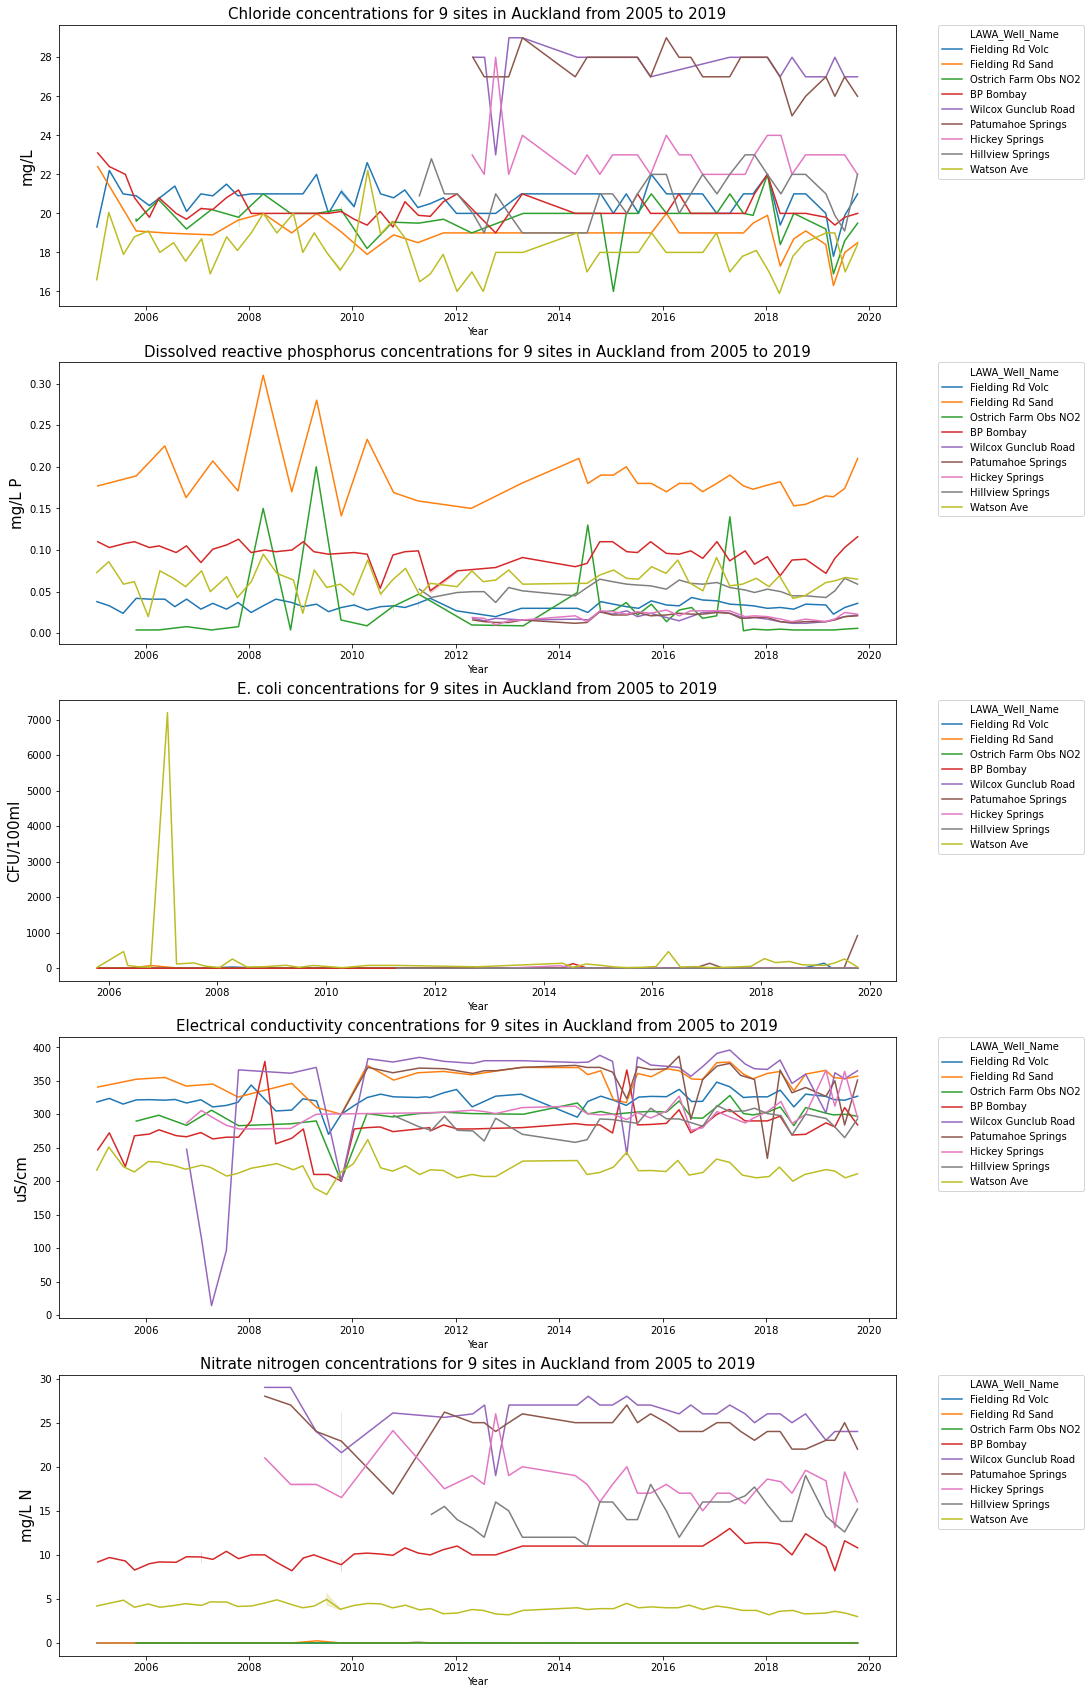

In [182]:
fig, axes = plt.subplots(5,1,figsize=(15,30))
## Chloride
## To making graph clearly to view, ylim is automatically setted as [14,30] instead of [0,30]
sns.lineplot(ax = axes[0],x= my_dict['Chloride'].index,y='Censored_Value', data=my_dict['Chloride'], hue='LAWA_Well_Name')
axes[0].set_title('Chloride concentrations for 9 sites in Auckland from 2005 to 2019',size = 15)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_ylabel('mg/L',size = 15)
axes[0].set_xlabel('Year')

## Dissolved reactive phosphorus
sns.lineplot(ax = axes[1],x= my_dict['Dissolved reactive phosphorus'].index,y = 'Censored_Value',data = my_dict['Dissolved reactive phosphorus'],hue ='LAWA_Well_Name')
axes[1].set_title('Dissolved reactive phosphorus concentrations for 9 sites in Auckland from 2005 to 2019',size = 15)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylabel('mg/L P',size = 15)
axes[1].set_xlabel('Year')

## E. coli
sns.lineplot(ax = axes[2],x= my_dict['E.coli'].index,y = 'Censored_Value',data = my_dict['E.coli'],hue ='LAWA_Well_Name')
axes[2].set_title('E. coli concentrations for 9 sites in Auckland from 2005 to 2019',size = 15)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2].set_ylabel('CFU/100ml',size = 15)
axes[2].set_xlabel('Year')

## Electrical conductivity
sns.lineplot(ax = axes[3],x= my_dict['Electrical conductivity'].index,y = 'Censored_Value',data = my_dict['Electrical conductivity'],hue ='LAWA_Well_Name')
axes[3].set_title('Electrical conductivity concentrations for 9 sites in Auckland from 2005 to 2019',size = 15)
axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[3].set_ylabel('uS/cm',size = 15)
axes[3].set_xlabel('Year')

## Nitrate nitrogen
sns.lineplot(ax = axes[4],x= my_dict['Nitrate nitrogen'].index,y = 'Censored_Value',data = my_dict['Nitrate nitrogen'],hue ='LAWA_Well_Name')
axes[4].set_title('Nitrate nitrogen concentrations for 9 sites in Auckland from 2005 to 2019',size = 15)
axes[4].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[4].set_ylabel('mg/L N',size = 15)
axes[4].set_xlabel('Year')

plt.show()

### Status_warning of Chloride
This analysis is to know general Chloride status and see how many days when Chloride status is not good for drinking. According to Drinking-water Standards for New Zealand (DWSNZ) benchmark, The guideline value for chloride concentrations in drinking water is 250 mg/L. Concentrations above this may affect the taste of the water.

In [183]:
%%sql 
DROP VIEW IF EXISTS Status_warning;

CREATE VIEW Status_warning AS
SELECT 
    Indicator, 
    Region_Name, 
    Sample_Date, 
    Censored_Value,
    LAWA_Well_Name,
    CASE WHEN Censored_Value<150 THEN 'Good for drinking'
         WHEN Censored_Value>=150 and Censored_Value<250 THEN 'Not too bad'
         WHEN Censored_Value>=250 THEN 'Too high to drink'
    ELSE 'Data is unavailable' END
    AS Status
FROM gwq 
WHERE Indicator = 'Chloride'

 * sqlite:///../datasets/Assignment3.sl3
Done.
Done.


[]

In [184]:
%%sql
SELECT
    Status,COUNT(Status)
FROM Status_warning
GROUP BY Status
ORDER BY COUNT(Status) DESC

 * sqlite:///../datasets/Assignment3.sl3
Done.


Status,COUNT(Status)
Good for drinking,28827
Not too bad,515
Too high to drink,415
Data is unavailable,5


As we can see, the general status of chloride concentration is not too bad that chloride concentration meets Drinking-water Standards. However, there are still 415 days when chloride concentration is over Drinking-water Standards.

### Rainfall analysis
The analysis is to see the different rainfall from 1960 to 2019 in North and South island

#### Joining rainfall_value with rainfall_station to create a view named rainfall

In [185]:
%%sql 
DROP VIEW IF EXISTS rainfall;

CREATE VIEW rainfall AS
SELECT rs.location_name,rs.station_name_niwa,rs.agent_number,rv.date,rv.rainfall,rv.Region
FROM rainfall_station as rs 
INNER JOIN rainfall_value as rv
ON rs.agent_number=rv.agent_number

 * sqlite:///../datasets/Assignment3.sl3
Done.
Done.


[]

In [186]:
%%sql 
DROP VIEW IF EXISTS rainfall_region;

CREATE VIEW rainfall_region AS
SELECT rainfall.location_name,rainfall.station_name_niwa,rainfall.agent_number,rainfall.date,rainfall.rainfall,region.*
FROM rainfall 
INNER JOIN region
ON rainfall.Region=region.Region

 * sqlite:///../datasets/Assignment3.sl3
Done.
Done.


[]

In [188]:
%%sql query << 
SELECT date,
       round(rainfall*100,1) AS rainfall_mm,
       Island
FROM rainfall_region
GROUP BY date, Island
ORDER BY Island

 * sqlite:///../datasets/Assignment3.sl3
Done.
Returning data to local variable query


In [189]:
df = query.DataFrame()
df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-%d')
df.set_index('date',inplace  = True)
df_rainfall =  pd.merge(df[df['Island']=='North'],df[df['Island']=='South'],on = 'date',how = 'outer',suffixes=('_North', '_South'))
df_rainfall = df_rainfall.resample('Q').mean()

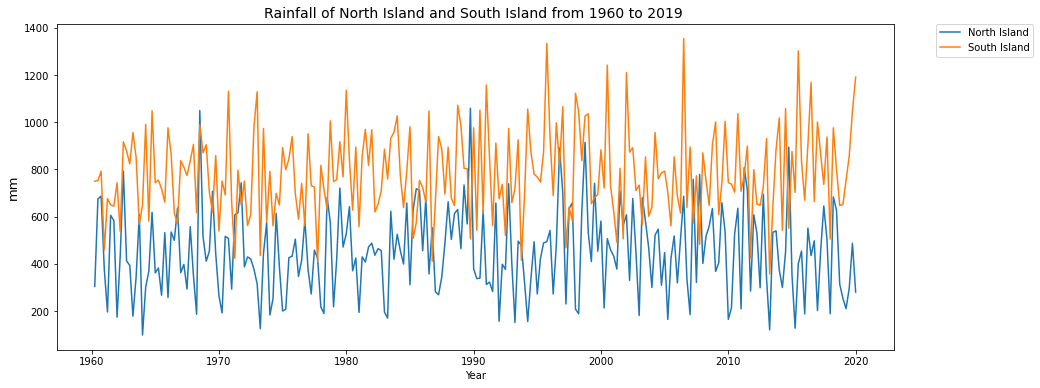

In [190]:
fig,ax = plt.subplots(figsize = (15,6))
ax.plot(df_rainfall.index,df_rainfall.loc[:,['rainfall_mm_North','rainfall_mm_South']])
ax.set_xlabel('Year')
ax.set_ylabel('mm',size = 13 )
ax.set_title('Rainfall of North Island and South Island from 1960 to 2019 ',size = 14)
ax.legend(['North Island','South Island',],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As we can see from the above graph, there is a seasonal rainfall trend in both the north and south island. Apart from that, the overall rainfall of the south island is bigger than the north island.

## Chloride and rainfall by region
The analysis is to try to find whether there is some relationship between Chloride concentration and rainfall by region.

#### Join ground water quality view with rainfall view to creat a  view  called gwqrainfall

In [191]:
%%sql
DROP VIEW IF EXISTS gwqrainfall;
CREATE VIEW gwqrainfall AS
SELECT gwq.*, rf.rainfall,rf.location_name,rf.station_name_niwa,rf.agent_number
FROM gwq as gwq
INNER JOIN rainfall as rf
ON gwq.Sample_Date = rf.date AND
   gwq.Region_Name =rf.Region

 * sqlite:///../datasets/Assignment3.sl3
Done.
Done.


[]

#### join ground water quality  and rainfall  view with region view to create a view named gwqrainfall_region

In [192]:
%%sql
DROP VIEW IF EXISTS gwqrainfall_region;
CREATE VIEW gwqrainfall_region AS
SELECT gwqrainfall.*, rg.Region_name_Māori,rg.Regional_council,rg.Seats,rg.Council_seat,rg.Island,rg.Land_area_km2,rg.Population,rg.Densit_pop_km2,rg.ISO_3166_2_Code
FROM gwqrainfall
INNER JOIN region as rg
ON gwqrainfall.Region_Name = rg.Region

 * sqlite:///../datasets/Assignment3.sl3
Done.
Done.


[]

In [194]:
%%sql query << 
SELECT 
      Region_Name,
      Indicator,
      Sample_Date,
      Censored_Value AS Chloride_concentration,
      LAWA_Well_Name AS gwq_site,
      rainfall,
      station_name_niwa AS rainfall_station,
      Island,
      Land_area_km2,
      Population,
      Densit_pop_km2
FROM gwqrainfall_region
WHERE Sample_Date >2005-01-01 AND
      Indicator = 'Chloride' 

 * sqlite:///../datasets/Assignment3.sl3
Done.
Returning data to local variable query


In [195]:
df = query.DataFrame()
df['Sample_Date'] = pd.to_datetime(df['Sample_Date'],format = '%Y-%m-%d')
df.set_index('Sample_Date',inplace  = True)
df 

,Region_Name,Indicator,Chloride_concentration,gwq_site,rainfall,rainfall_station,Island,Land_area_km2,Population,Densit_pop_km2
Sample_Date,,,,,,,,,,
2012-05-01,Auckland,Chloride,28.0,Patumahoe Springs,0.2,Whangaparaoa Aws,North,4941,1717500,347.60
2012-05-01,Auckland,Chloride,28.0,Patumahoe Springs,1.4,Auckland Aero,North,4941,1717500,347.60
2012-07-20,Auckland,Chloride,27.0,Patumahoe Springs,0.0,Whangaparaoa Aws,North,4941,1717500,347.60
2012-07-20,Auckland,Chloride,27.0,Patumahoe Springs,0.0,Auckland Aero,North,4941,1717500,347.60
2012-10-09,Auckland,Chloride,27.0,Patumahoe Springs,0.2,Whangaparaoa Aws,North,4941,1717500,347.60
...,...,...,...,...,...,...,...,...,...,...
2019-06-14,West Coast,Chloride,9.7,None,0.0,Reefton Ews,South,23245,32400,1.39
2019-09-13,West Coast,Chloride,10.0,None,10.8,Hokitika Aero,South,23245,32400,1.39
2019-09-13,West Coast,Chloride,10.0,None,16.6,Reefton Ews,South,23245,32400,1.39


In [196]:
# Creating dictionary to save all dataframe because variable names can not be string
my_dict = {}                             
for a in list(df.groupby('Region_Name').groups.keys()):
    my_dict[a] = df[df['Region_Name'] == a].resample('Q').mean()

# Region column dissappeared because groupby only works for numeric columns
for i in list(df.groupby('Region_Name').groups.keys()):
    my_dict[i]['Region_Name'] = i

# Appending all region dataframe into a big dataframe
appended_data = []
for i in list(df.groupby('Region_Name').groups.keys()):
    appended_data.append(my_dict[i])
df = pd.concat(appended_data)
df

,Chloride_concentration,rainfall,Land_area_km2,Population,Densit_pop_km2,Region_Name
Sample_Date,,,,,,
2005-03-31,20.350000,0.325000,4941.0,1717500.0,347.60,Auckland
2005-06-30,21.175000,0.050000,4941.0,1717500.0,347.60,Auckland
2005-09-30,20.300000,5.366667,4941.0,1717500.0,347.60,Auckland
2005-12-31,19.714286,2.028571,4941.0,1717500.0,347.60,Auckland
2006-03-31,19.766667,2.200000,4941.0,1717500.0,347.60,Auckland
...,...,...,...,...,...,...
2018-12-31,6.042857,9.857143,23245.0,32400.0,1.39,West Coast
2019-03-31,8.220000,7.086667,23245.0,32400.0,1.39,West Coast
2019-06-30,6.672222,2.955556,23245.0,32400.0,1.39,West Coast


In [197]:
pivot_Chloride = df.pivot_table(index = ['Sample_Date'],columns = 'Region_Name')['Chloride_concentration']
pivot_rainfall = df.pivot_table(index = ['Sample_Date'],columns = 'Region_Name')['rainfall']

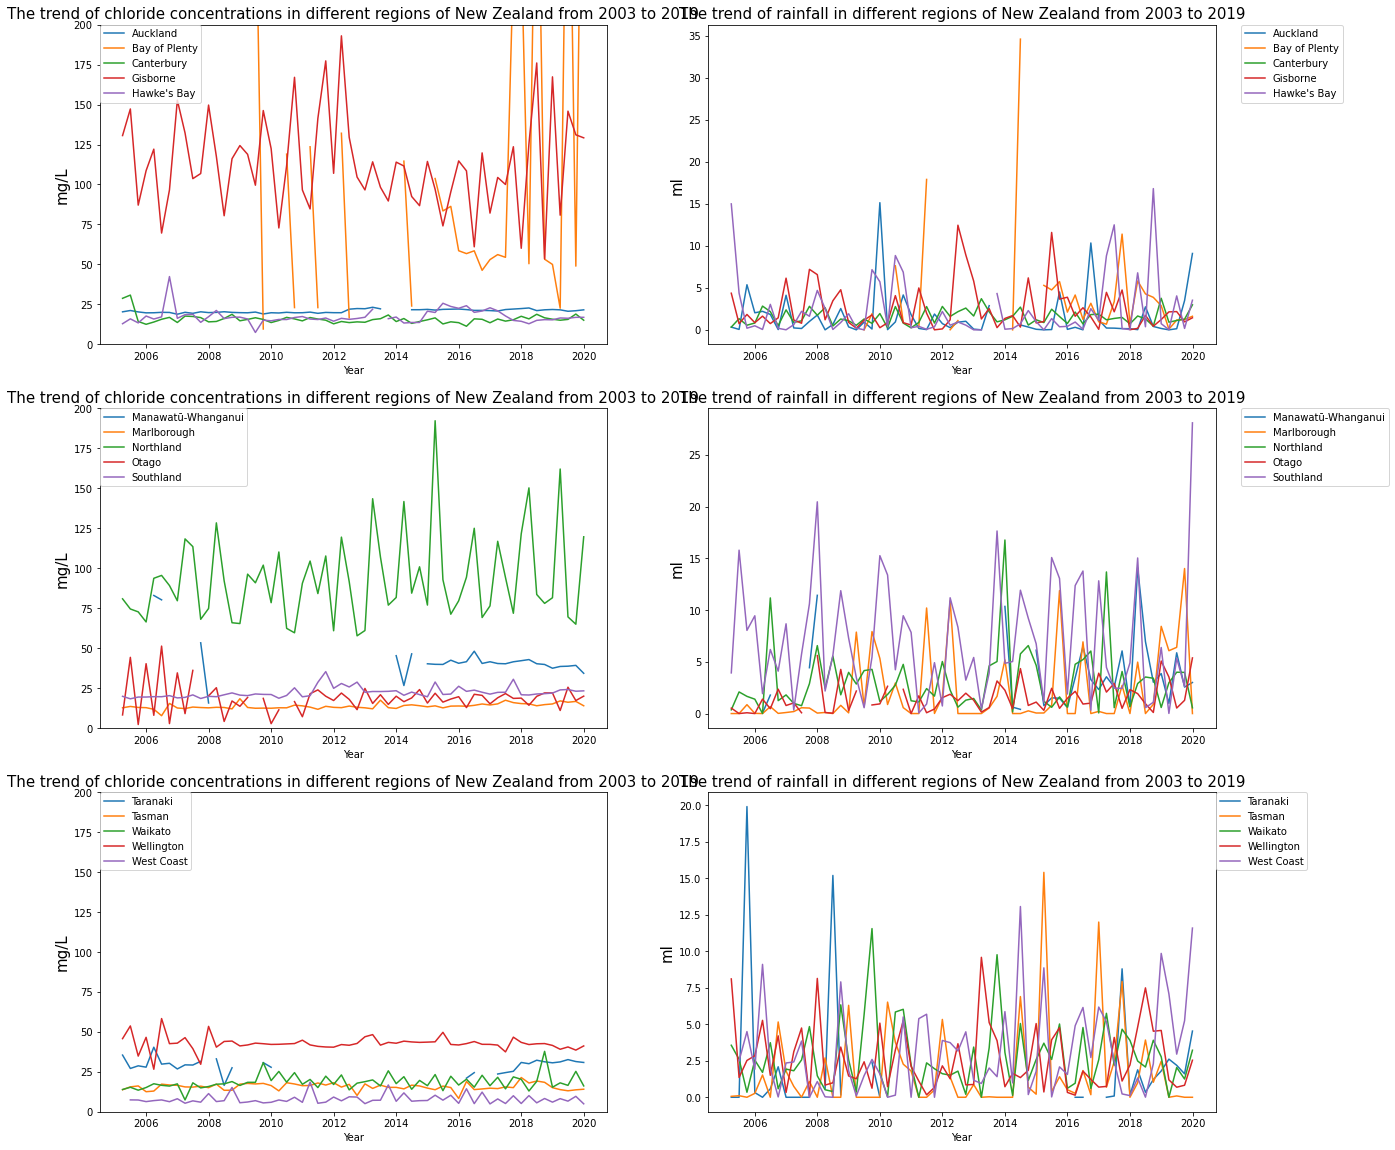

In [198]:
fig, axes = plt.subplots(3,2,figsize=(20,20))
###############################################################################################################################
## Auckland Bay of Plenty Canterbury Gisbone Hawke's  Bay 
# Chloride concentration
axes[0,0].plot(pivot_Chloride.index,pivot_Chloride.loc[:,'Auckland':"Hawke's Bay"])
axes[0,0].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[0,0].set_ylabel('mg/L',size = 15)
axes[0,0].set_xlabel('Year')
axes[0,0].legend(pivot_Chloride.loc[:,'Auckland':"Hawke's Bay"].columns.values,bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
axes[0,0].set_ylim(0,200)

# Rainfall 
axes[0,1].plot(pivot_rainfall.index,pivot_rainfall.loc[:,'Auckland':"Hawke's Bay"])
axes[0,1].set_title('The trend of rainfall in different regions of New Zealand from 2003 to 2019',size = 15)
axes[0,1].set_ylabel('ml',size = 15)
axes[0,1].set_xlabel('Year')
axes[0,1].legend(pivot_Chloride.loc[:,'Auckland':"Hawke's Bay"].columns.values,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
###############################################################################################################################
## Manawatū-Whanganui Marlborough Northland Otago Southland
# Chloride concentration
axes[1,0].plot(pivot_Chloride.index,pivot_Chloride.loc[:,'Manawatū-Whanganu':"Southland"])
axes[1,0].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[1,0].set_ylabel('mg/L',size = 15)
axes[1,0].set_xlabel('Year')
axes[1,0].legend(pivot_Chloride.loc[:,'Manawatū-Whanganu':"Southland"].columns.values,bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
axes[1,0].set_ylim(0,200)
# Rainfall 
axes[1,1].plot(pivot_rainfall.index,pivot_rainfall.loc[:,'Manawatū-Whanganu':"Southland"])
axes[1,1].set_title('The trend of rainfall in different regions of New Zealand from 2003 to 2019',size = 15)
axes[1,1].set_ylabel('ml',size = 15)
axes[1,1].set_xlabel('Year')
axes[1,1].legend(pivot_Chloride.loc[:,'Manawatū-Whanganu':"Southland"].columns.values,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
###############################################################################################################################
## Taranaki Tasman Waikato Wellington West Coast
# Chloride concentration
axes[2,0].plot(pivot_Chloride.index,pivot_Chloride.loc[:,'Taranaki':"West Coast"])
axes[2,0].set_title('The trend of chloride concentrations in different regions of New Zealand from 2003 to 2019',size = 15)
axes[2,0].set_ylabel('mg/L',size = 15)
axes[2,0].set_xlabel('Year')
axes[2,0].legend(pivot_Chloride.loc[:,'Taranaki':"West Coast"].columns.values,bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.)
axes[2,0].set_ylim(0,200)
# Rainfall 
axes[2,1].plot(pivot_rainfall.index,pivot_rainfall.loc[:,'Taranaki':"West Coast"])
axes[2,1].set_title('The trend of rainfall in different regions of New Zealand from 2003 to 2019',size = 15)
axes[2,1].set_ylabel('ml',size = 15)
axes[2,1].set_xlabel('Year')
axes[2,1].legend(pivot_Chloride.loc[:,'Taranaki':"West Coast"].columns.values,bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)


As we can see from the above table, graphs on the first column show the chloride concentration and graphs on the second column show the rainfall of corresponding regions. 

There is a seasonal rainfall trend in most regions but only a few regions get an obvious seasonal trend of chloride concentration. And also there is no obvious evidence indicating that there is some correlation between chloride concentration and rainfall.